## SIM Training by Stein's Method

In [19]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score

from pysim import SimClassifier

# Case 1: Logit Function

In [20]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 1 / (1 + np.exp(-(np.dot(x, beta)))) + 0.1 * np.random.randn(n_samples)
y = y - np.mean(y)
y[y <= 0] = 0
y[y > 0] = 1

The best hyperparameter combination can be selected via cross-validation

In [21]:
%%time 

param_grid = {"method": ["first_order", "second_order", "first_order_thres", "marginal_regression", "ols"],
              "knot_dist": ["uniform", "quantile"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SimClassifier(spline="smoothing_spline_mgcv", degree=3, knot_num=10, random_state=0), iid=False,
                    cv=KFold(5, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=10, error_score=np.nan)
grid.fit(x, y)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   34.3s

CPU times: user 7.32 s, sys: 8.55 s, total: 15.9 s
Wall time: 47.4 s
Parser   : 185 ms


In [22]:
grid.best_params_

{'knot_dist': 'uniform',
 'method': 'first_order_thres',
 'reg_gamma': 100.0,
 'reg_lambda': 0.2}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [23]:
clf = grid.best_estimator_
clf

SimClassifier(knot_dist='uniform', method='first_order_thres', reg_gamma=100.0,
              reg_lambda=0.2)

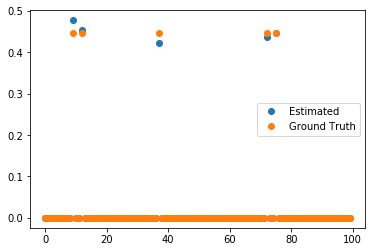

In [24]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

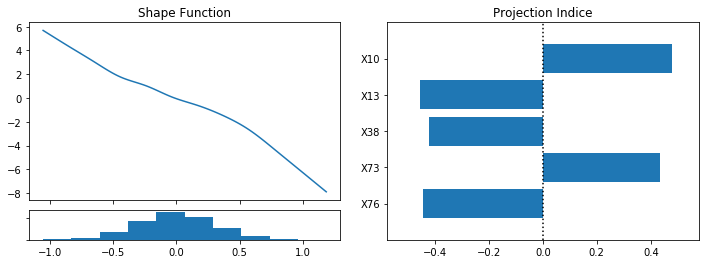

In [25]:
grid.best_estimator_.visualize()

In [26]:
roc_auc_score(y, grid.predict_proba(x)[:, 1])

0.7765505681564544

## Case 2: Quadratic Ridge Function

In [27]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [28]:
%%time 

param_grid = {"method": ["first_order", "second_order", "first_order_thres", "marginal_regression", "ols"],
              "knot_dist": ["uniform", "quantile"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SimClassifier(spline="smoothing_spline_mgcv", degree=3, knot_num=10, random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    6.3s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


CPU times: user 6.81 s, sys: 11.1 s, total: 17.9 s
Wall time: 6.77 s


In [29]:
grid.best_params_

{'knot_dist': 'uniform',
 'method': 'second_order',
 'reg_gamma': 0.01,
 'reg_lambda': 0.1}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [30]:
clf = grid.best_estimator_
clf

SimClassifier(knot_dist='uniform', method='second_order', reg_gamma=0.01)

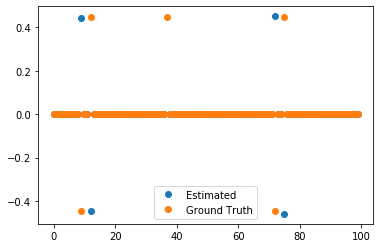

In [31]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

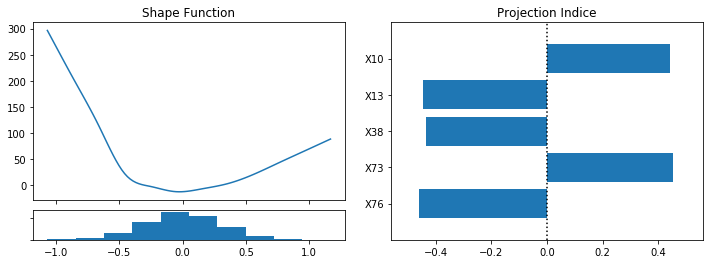

In [32]:
grid.best_estimator_.visualize()

## Case 3: Improve a rough estimator via middle update

In [33]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

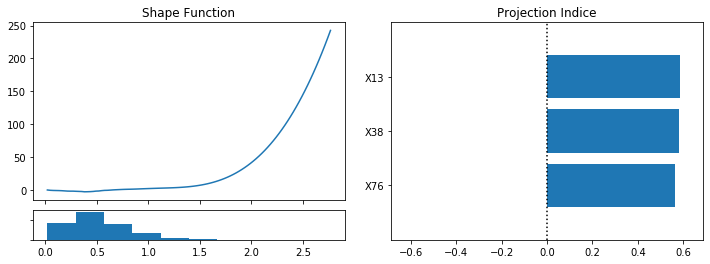

CPU times: user 3.32 s, sys: 6.3 s, total: 9.62 s
Wall time: 884 ms
Compiler : 163 ms


In [34]:
%%time 
clf = SimClassifier(degree=3, knot_num=20, reg_lambda=0.1, reg_gamma=10**(0), spline="smoothing_spline_mgcv", random_state=0)
clf.fit(x, y)
clf.visualize()

To improve the solution, we provide two options for inner update: **adam optimizer** and **BFGS optimizer**.

Middle iter: 1 Inner iter: 1 with validation loss: 0.39044
Middle iter: 1 Inner iter: 2 with validation loss: 0.38676
Middle iter: 1 Inner iter: 3 with validation loss: 0.38243
Middle iter: 1 Inner iter: 4 with validation loss: 0.37953
Middle iter: 1 Inner iter: 5 with validation loss: 0.37682
Middle iter: 1 Inner iter: 6 with validation loss: 0.37314
Middle iter: 1 Inner iter: 7 with validation loss: 0.37041
Middle iter: 1 Inner iter: 8 with validation loss: 0.36712
Middle iter: 1 Inner iter: 9 with validation loss: 0.36383
Middle iter: 1 Inner iter: 10 with validation loss: 0.36108
Middle iter: 1 Inner iter: 11 with validation loss: 0.35796
Middle iter: 1 Inner iter: 12 with validation loss: 0.35484
Middle iter: 1 Inner iter: 13 with validation loss: 0.35202
Middle iter: 1 Inner iter: 14 with validation loss: 0.34893
Middle iter: 1 Inner iter: 15 with validation loss: 0.34613
Middle iter: 1 Inner iter: 16 with validation loss: 0.34328
Middle iter: 1 Inner iter: 17 with validation los

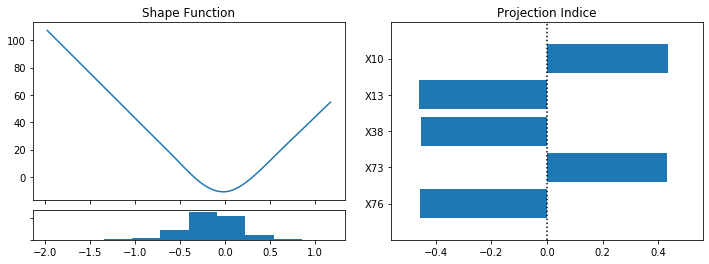

In [35]:
clf = SimClassifier(degree=3, knot_num=10, reg_lambda=0.1, reg_gamma=10**(0),
                    knot_dist="uniform", spline="smoothing_spline_mgcv", random_state=0)
clf.fit(x, y)
clf.fit_middle_update(x, y, method="adam", n_middle_iter_no_change=1, n_inner_iter_no_change=3,
                     learning_rate=0.001, batch_size=1000, verbose=True)
clf.visualize()

Middle iter: 1 with validation loss: 0.15065
Middle iter: 2 with validation loss: 0.07882
Middle iter: 3 with validation loss: 0.07898


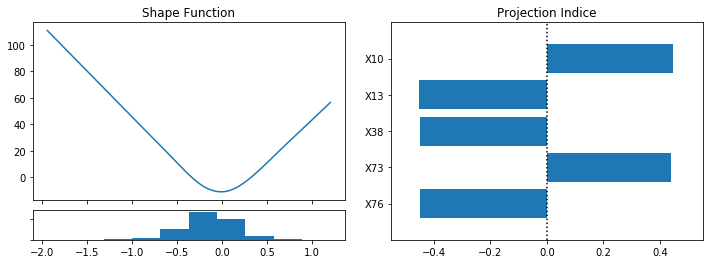

In [36]:
clf = SimClassifier(degree=3, knot_num=10, reg_lambda=0.1, reg_gamma=10**(0),
                    spline="smoothing_spline_mgcv", knot_dist="uniform", random_state=0)
clf.fit(x, y)
clf.fit_middle_update(x, y, method="bfgs", n_middle_iter_no_change=1, n_inner_iter_no_change=20,
                     max_inner_iter=100, verbose=True)
clf.visualize()

**Remark**: fit_inner_update is not available for spline="p_spline" or "mono_p_spline"